<a href="https://colab.research.google.com/github/Mateus-Priolo/Trabalho-Intro-Python/blob/main/trabalho_final_Mateus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**pyGenomeTracks**

O pyGenomeTracks (PGT) é uma biblioteca para visualização interativa de dados genômicos: https://github.com/deeptools/pyGenomeTracks. Permite a criação de trilhas genômicas personalizadas, como gráficos de leituras de RNA-seq, anotações genômicas e outros elementos de interesse. Com o PGT, é possível integrar várias fontes de dados de uma ampla variedade de ensaios genômicos e gerar gráficos para publicações. O PGT pode ser usado em linha de comando ou ferramenta baseada no Galaxy. Este último está disponível em https://usegalaxy.eu com todas as opções de configuração ou pode ser instalado em qualquer instância local do Galaxy. Ele fornece uma maneira fácil para os usuários executarem suas análises no Galaxy de maneira transparente e reproduzível [Lopez-Delisle et al. 2020](https://doi.org/10.1093/bioinformatics/btaa692).

Para este trabalho, utilizei 2 arquivos de transcriptoma de linhagens celulares utilizadas em nosso laboratório. Esses dados brutos estão disponiveis no ncbi (SRR11773880 e SRR11814610), sendo escolhidas respectivamente uma de astrócito e uma de tumor cerebral grau III. Para utilizá-las com o PGT realizei o processamento desses dados até obter o arquivo BAM, alinhado ao genoma referência, no caso usei o GRCh37, por isso este é usado também nesses códigos. Por fim, os arquivos BAM foram convertidos para bigwig, o qual é lido no PGT. O arquivo BigWig é um formato compacto e binário usado para armazenar dados de valores em larga escala ao longo de um genoma. É especialmente útil para representar dados de cobertura de leituras, como dados de expressão gênica de RNA-Seq. É interessante ressaltar que, por mais que os arquivos brutos sejam muito pesados, por se tratarem de genomas humanos, todas essas etapas e também posteriores podem ser feitas em servidores públicos, um bastante utilizado é o Galaxy: [usegalaxy.org](https://usegalaxy.org/?tool_id=toolshed.g2.bx.psu.edu%2Frepos%2Fiuc%2Fpygenometracks%2FpygenomeTracks%2F3.8%2Bgalaxy1&version=latest), pode transferir dados diretamente do ncbi para este servidor, sem mesmo ter que baixá-los em sua máquina pessoal, várias ferramentas de análises genômicas estão disponíveis no Galaxy, inclusive o próprio pyGenomeTracks.

Instala o BEDTools, pre-requisito para o PGT [bedtools: a powerful toolset for genome arithmetic](https://bedtools.readthedocs.io/en/latest/index.html)

In [ ]:
!apt-get -qq install bedtools

Instala o PGT

In [ ]:
!pip install pygenometracks

In [ ]:
!pip install requests

utilizarei a biblioteca requests para fazer uma solicitação GET para o Ensembl REST API, buscando informações sobre os genes fornecidos. A resposta é analisada e as coordenadas genômicas (cromossomo, posição inicial e posição final) são extraídas da resposta e retornadas como resultado da função def get_gene_coordinates_from_ensembl.
Essas informações foram posteriormente utilizadas para gerar rastreamentos genômicos usando o pyGenomeTracks e salvar os resultados em arquivos PNG para cada gene informado ao programa.

In [ ]:
import requests

def get_gene_coordinates_from_ensembl(gene_name, genome_assembly="GRCh37"):
    base_url = "http://grch37.rest.ensembl.org/"  # conecta ao GRCh37 Ensembl REST API
    endpoint = f"lookup/symbol/human/{gene_name}?expand=1"

    headers = {"Content-Type": "application/json"}

    try:
        response = requests.get(base_url + endpoint, headers=headers)
        if response.ok:
            response_data = response.json()
            chromosome = response_data["seq_region_name"]
            start_coord = response_data["start"]
            end_coord = response_data["end"]
            return chromosome, start_coord, end_coord
        else:
            return None, None, None
    except requests.exceptions.RequestException as e:
        print(f"Error retrieving gene coordinates: {e}")
        return None, None, None

gene_name = "HJURP"
genome_assembly = "GRCh37"

chromosome, start_coord, end_coord = get_gene_coordinates_from_ensembl(gene_name, genome_assembly)
if chromosome and start_coord and end_coord:
    print(f"Start coordinate: {start_coord}, End coordinate: {end_coord}.")
else:
    print(f"O Gene {gene_name} não foi encontrado no banco GRCh37 do Ensembl.")
regiao=f"{chromosome}:{start_coord}-{end_coord}"
print(f"O gene {gene_name} está localizado em chr{regiao}")

Start coordinate: 234742062, End coordinate: 234763212.
O gene HJURP está localizado em chr2:234742062-234763212


Agora utilizarei as coordenadas do gene de interesse para plotar esta região nos meus arquivos de RNA-seq. Além disso, adicionei arquivos do genoma referência em questão (baixados do UCSC) para adicionar na mesma imagem o que há nessa região nos arquivos referência.
dbNsfpGerpNr é um transcriptoma, e hg19.ncbiRefSeq.gtf é um arquivo GTF curado (do RefSeq) que contém informações anotadas como exons, íntrons e as variantes transcricionais de cada gene.

O PGT precisa de um arquivo de configuração, criado com o comando  "make_track_file", usado para personalizar a aparência e o comportamento dos tracks no gráfico gerado pelo PGT. Pode-se definir várias opções, como o tipo de dados a serem plotados, a cor e o estilo de exibição dos dados, a escala do eixo y, a região do genoma a ser exibida, entre outras configurações. Para este trabalho, apenas usei as coordenadas de genes e os arquivos referência.

In [ ]:
!make_tracks_file --trackFiles SRR11773880_ACBRI371.bigwig SRR11814610_UW467.bigwig dbNsfpGerpNr.bw hg19.ncbiRefSeq.gtf.gz -o tracks.ini

In [ ]:
!pyGenomeTracks --tracks tracks.ini --region 2:234742062-234763212 -o HJURP.png

Podemos visualizar abaixo o gene HJURP, nosso principal foco de estudos. Os picos mostram regiões de muitas leituras de sequenciamento, correspondendo aos exons, a figura dessa região no arquivo GTF mostra que esses picos mapeam exatamente nos exons anotados e existem 3 isoformas (variantes de splicing) desse gene.
Esta ferramenta mostrou uma perspectiva muito interessante, visualizando dados de RNA-seq, os quais haviam sido usados apenas para fins quantitativos.

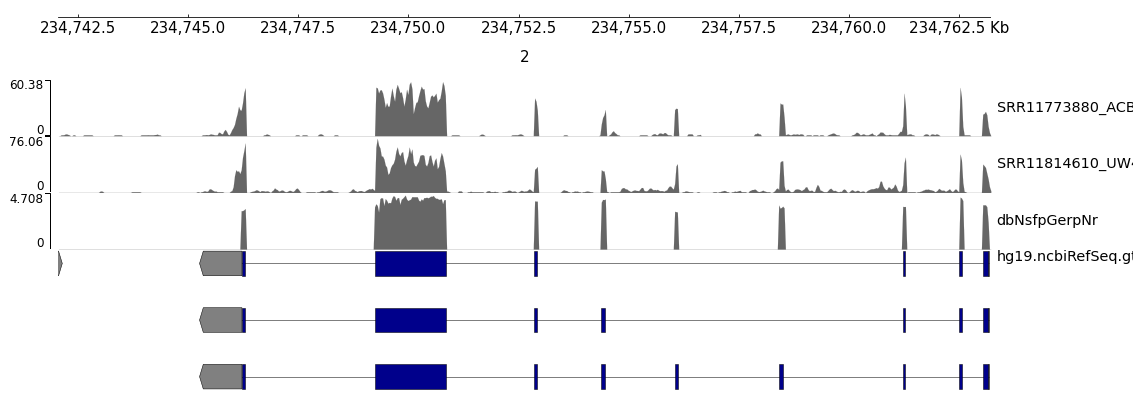

In [ ]:
from IPython.display import Image
Image(filename='HJURP.png')

De nossas análises de RNA-seq, obtivemos uma lista de genes diferencialmente expressos entre linhagens saudáveis e tumorais, da qual selecionei alguns e coloquei em uma coluna de um arquivo txt (DEG_list.txt), DEG de differentially expressed genes.

Os dois próximos códigos demoram alguns minutos para rodar por conta do número de genes na lista. Mas é interessante para vermos que podemos automatizar processos repetitivos.

In [ ]:
import requests

def obter_coordenadas_ensembl(gene_name, genome_assembly="GRCh37"):
    base_url = "http://grch37.rest.ensembl.org/"
    endpoint = f"lookup/symbol/human/{gene_name}?expand=1"
    headers = {"Content-Type": "application/json"}

    try:
        response = requests.get(base_url + endpoint, headers=headers)
        if response.ok:
            response_data = response.json()
            chromosome = response_data["seq_region_name"]
            start_coord = response_data["start"]
            end_coord = response_data["end"]
            return chromosome, start_coord, end_coord
        else:
            return None, None, None
    except requests.exceptions.RequestException as e:
        return None, None, None

# Lê os genes do arquivo "DEG_list.txt" e armazena em uma lista
with open("DEG_list.txt") as f:
    gene_names = f.read().splitlines()

# Cria um dicionário
gene_regions = {}

# Obtém as coordenadas de cada item da lista e as armazena no dicionário, para cada gene
for gene_name in gene_names:
    chromosome, start_coord, end_coord = obter_coordenadas_ensembl(gene_name)
    if chromosome and start_coord and end_coord:
        gene_region = f"{chromosome}:{start_coord}-{end_coord}"
        gene_regions[gene_name] = gene_region
    else:
        print(f"Gene {gene_name} não encontrado no banco Ensembl (GRCh37), obtendo demais coordenadas...")

# imprime as coordenadas obtidas do ensembl
for gene_name in gene_names:
    gene_region = gene_regions.get(gene_name)
    if gene_region:
        print(f"{gene_name} está localizado em chr:{gene_region}")
    else:
        print(f"Gene {gene_name} não encontrado no banco Ensembl (GRCh37).")

Gene NECTIN3 não encontrado no banco Ensembl (GRCh37), obtendo demais coordenadas...
CD44 está localizado em chr:11:35160417-35253949
CD47 está localizado em chr:3:107762145-107809872
COL1A1 está localizado em chr:17:48260650-48278993
COL4A1 está localizado em chr:13:110801318-110959496
COL4A2 está localizado em chr:13:110958159-111165374
COL4A6 está localizado em chr:X:107386780-107682727
COL6A3 está localizado em chr:2:238232646-238323018
ITGA1 está localizado em chr:5:52083730-52255040
ITGA4 está localizado em chr:2:182321929-182400914
ITGA7 está localizado em chr:12:56078352-56109827
ITGA8 está localizado em chr:10:15555948-15762124
ITGB6 está localizado em chr:2:160956177-161128399
LAMA2 está localizado em chr:6:129204342-129837714
LAMA3 está localizado em chr:18:21269407-21535030
LAMA4 está localizado em chr:6:112429963-112576141
RELN está localizado em chr:7:103112231-103629963
SDC4 está localizado em chr:20:43953928-43977064
SPP1 está localizado em chr:4:88896819-88904562
SV2B 

Agora executarei o PGT em um for loop para todos os genes da lista, utilizando suas respectivas coordenadas. Este código salvará uma imagem para cada gene da lista.

In [ ]:
for gene_name in gene_names:
    gene_region = gene_regions.get(gene_name)
    if gene_region:
        print(f"Running pyGenomeTracks for {gene_name}...")
        !pyGenomeTracks --tracks tracks.ini --region {gene_region} -o {gene_name}.png
    else:
        print(f"Coordenadas inválidas para o gene {gene_name}. Pulando pyGenomeTracks para este gene.")

print("pyGenomeTracks finalizado para todos os genes da lista encontrados no Ensembl.")

Running pyGenomeTracks for CD44...
INFO:pygenometracks.tracksClass:initialize 1. [x-axis]
INFO:pygenometracks.tracksClass:initialize 2. [spacer]
INFO:pygenometracks.tracksClass:initialize 3. [SRR11773880_ACBRI371]
INFO:pygenometracks.tracksClass:initialize 4. [SRR11814610_UW467]
INFO:pygenometracks.tracksClass:initialize 5. [dbNsfpGerpNr]
INFO:pygenometracks.tracksClass:initialize 6. [hg19.ncbiRefSeq.gtf]
100% 13/13 [00:00<00:00, 1865.41it/s]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:1.832714557647705
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 14.22872340425532. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [SRR11773880_ACBRI371]
INFO:pygenometracks.tracksClass:plotting 4. [SRR11814610_UW467]
INFO:pygenometracks.tracksClass:plotting 5. [dbNsfpGerpNr]
INFO:pygenometracks.tracksClass:plotting 6. [hg19.n

Como ele gera e salva as imagens sem printá-las, com o código abaixo podemos visualizar algumas de forma mais simples:

In [ ]:
from IPython.display import display

imagens= ['ADCYAP1R1.png', 'AREG.png', 'CCND1.png', 'CD44.png', 'CDKN1A.png']

for filename in imagens:
    display(Image(filename=filename))

Obs: pode-se aperfeiçoar a visualização dos plots utilizando-se vários parâmetros do PGT (vide sua documentação).